<a href="https://colab.research.google.com/github/onalisamayor/Tugas_DL4/blob/main/Tugas_DL4/Tugas_TM4/batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'natural-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F42780%2F75676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T050003Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D52c8f4e769b311450a1258182357ae918415e7455d08c7e99b201c2d5b1771470c48c6646bdbd11a3cee6f81507b9ee406546b91188a36b9287123769ec857970dd980be0259444f822e1cf8a2fbd5c74c68fb741f60f07333f476b37070d389f8b49b71fa9289474e15211ca1ce48b74abc3058af4615d47c5eed76fd806a8ef50423b346fc7366c419a25a414c25096d8f9b39001de309a62c430b08cf7dd2f94d59f7c341c4b48512136b4d2f0735aa8e469fe686314b08b3f4429f80d142e02053f9d125af4000328741ee7b12bffb4b0dcbdf471b4ea9571c58576da48c6ce30505ede9ca874f4c26f72227412e6924573e90d1b76e4eb994ea4bb35c95'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 358905792 bytes downloaded
Downloaded and uncompressed: natural-images
Data source import complete.


# Description
### This dataset contains 6,899 images from 8 distinct classes compiled from various sources (see Acknowledgements). The classes include airplane, car, cat, dog, flower, fruit, motorbike and person.

# import lib

In [53]:
from IPython.display import Image, display
# preprocessing and processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# ploting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.keras.utils import plot_model
# split data
from sklearn.model_selection import train_test_split
# CNN
from keras import models, layers
# val
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# plot all images
from pathlib import Path
import random
from PIL import Image

In [54]:
import os

labels = os.listdir('../input/natural-images/data/natural_images/')
print(labels)

['car', 'person', 'dog', 'motorbike', 'flower', 'airplane', 'cat', 'fruit']


# show some images

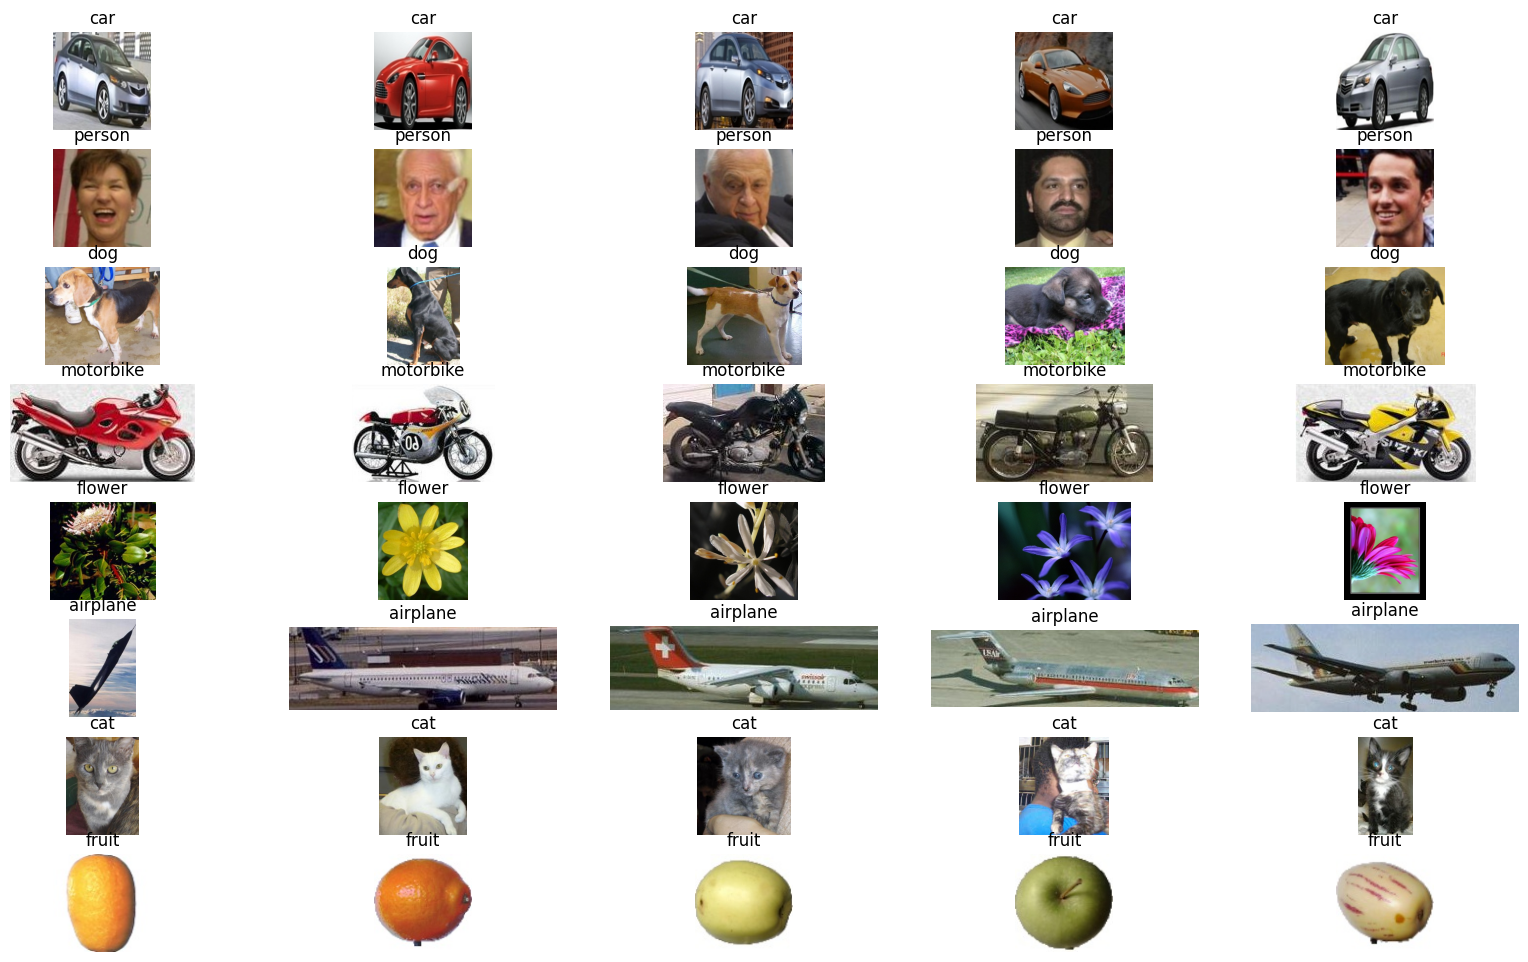

In [55]:
labels = os.listdir('../input/natural-images/data/natural_images/')
path = Path('/kaggle/input/natural-images/natural_images')
def displayRandomImagesFromEveryFolder(directory=path, samplesPerFolder=5):

    fig = plt.figure(figsize=(20,15))

    for rowIndex in range(1, 9):
        subdirectory = str(rowIndex)
        path = directory/labels[rowIndex -1]
        images = os.listdir(path)
        for sampleIndex in range(1,samplesPerFolder+1):
            randomNumber = random.randint(0, len(images)-1)
            image = Image.open(path/images[randomNumber])
            ax = fig.add_subplot(10, 5, samplesPerFolder*rowIndex + sampleIndex)
            ax.axis("off")

            plt.title(str(labels[rowIndex -1]))
            plt.imshow(image, cmap='gray')


    plt.show()

displayRandomImagesFromEveryFolder()

# vis count image for all classes

In [56]:
num = []
for label in labels:
    path = '../input/natural-images/data/natural_images/{0}/'.format(label)
    folder_data = os.listdir(path)
    k = 0
    # print('\n',f'=====   {label.upper()}   =====')
    for image_path in folder_data:
        if k < 5:
            #display(Image(path+image_path))
            pass
        k = k+1
    num.append(k)
#     print(f'count : {k} images , label : {label} class')

In [57]:
fig = go.Figure(data=[go.Bar(
            x=labels, y=num,
            text=num,
            textposition='auto',
        )])
fig.update_layout(title_text='NUMBER OF IMAGES CONTAINED IN EACH CLASS')
fig.show()

# show shaps and stadardizing input data

In [58]:
x_data =[]
y_data = []
import cv2
for label in labels:
    path = '../input/natural-images/data/natural_images/{0}/'.format(label)
    folder_data = os.listdir(path)
    for image_path in folder_data:
        image = cv2.imread(path+image_path)
        image_resized = cv2.resize(image, (120,120))
        x_data.append(np.array(image_resized))
        y_data.append(label)
        pass
    pass

x_data = np.array(x_data)
y_data = np.array(y_data)
print('the shape of X is: ', x_data.shape, 'and that of Y is: ', y_data.shape)
x_data = x_data.astype('float32')/255

the shape of X is:  (6899, 120, 120, 3) and that of Y is:  (6899,)


# converting y data into categorical data

In [59]:
y_encoded = LabelEncoder().fit_transform(y_data)
y_categorical = to_categorical(y_encoded)

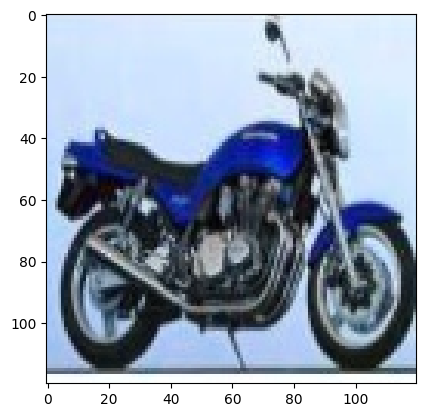

motorbike


In [60]:
r = 2999
x = x_data[r]
# x = x.reshape((28, 28))
plt.imshow(x)
plt.show()
print(y_data[r])

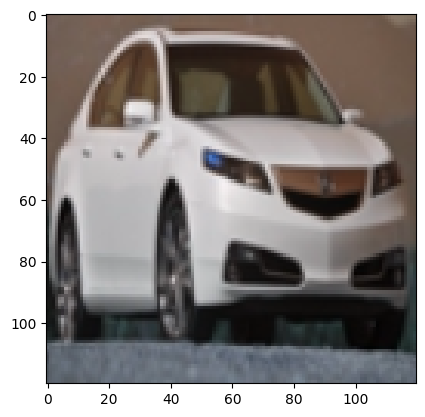

In [61]:
x = x_data[0]
# x = x.reshape((28, 28))
plt.imshow(x)
plt.show()
# x

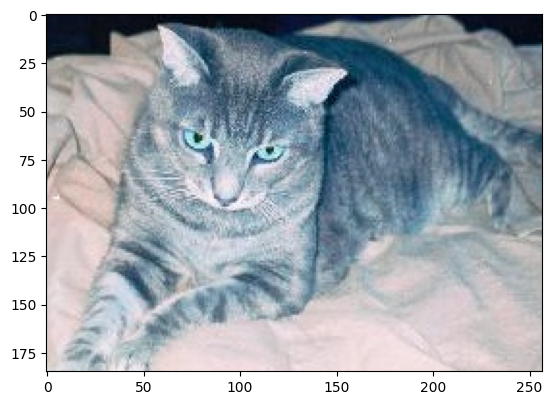

In [62]:
zz = cv2.imread('../input/natural-images/natural_images/cat/cat_0005.jpg')
plt.imshow(zz)
plt.show()

array([[[ 11,  15,  33],
        [ 11,  15,  33],
        [ 13,  17,  35],
        ...,
        [ 10,  14,  25],
        [ 10,  14,  25],
        [  7,  13,  24]],

       [[ 10,  14,  32],
        [ 10,  14,  32],
        [ 11,  15,  33],
        ...,
        [  9,  13,  24],
        [ 10,  14,  25],
        [  7,  13,  24]],

       [[  8,  15,  32],
        [  8,  15,  32],
        [  9,  16,  33],
        ...,
        [  7,  13,  24],
        [  9,  15,  26],
        [  8,  12,  23]],

       ...,

       [[224, 213, 209],
        [221, 212, 208],
        [217, 208, 205],
        ...,
        [196, 188, 188],
        [201, 193, 193],
        [198, 188, 188]],

       [[226, 216, 216],
        [223, 215, 215],
        [221, 213, 214],
        ...,
        [199, 191, 191],
        [208, 198, 198],
        [205, 193, 193]],

       [[228, 218, 224],
        [226, 219, 224],
        [221, 215, 220],
        ...,
        [204, 195, 192],
        [206, 197, 194],
        [206, 194, 192]]], dtype=uint8)
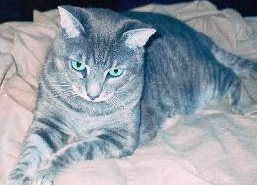

In [63]:
zz

# shuffle data

In [64]:
r = np.arange(x_data.shape[0])
np.random.seed(42)
np.random.shuffle(r)
X = x_data[r]
Y = y_categorical[r]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

# create a CNN model

In [65]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

# compile the CNN model

In [66]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# training model

In [67]:
history = model.fit(X_train, Y_train, epochs=100, validation_split=0.2, batch_size=64)

Epoch 1/100
58/58 [==============================] - 5s 55ms/step - loss: 1.2738 - accuracy: 0.5997 - val_loss: 0.6177 - val_accuracy: 0.7838
Epoch 2/100
58/58 [==============================] - 2s 37ms/step - loss: 0.4975 - accuracy: 0.8253 - val_loss: 0.4012 - val_accuracy: 0.8562
Epoch 3/100
58/58 [==============================] - 2s 41ms/step - loss: 0.3141 - accuracy: 0.8880 - val_loss: 0.3423 - val_accuracy: 0.8659
Epoch 4/100
58/58 [==============================] - 2s 38ms/step - loss: 0.2011 - accuracy: 0.9286 - val_loss: 0.3179 - val_accuracy: 0.8832
Epoch 5/100
58/58 [==============================] - 2s 38ms/step - loss: 0.1544 - accuracy: 0.9459 - val_loss: 0.3113 - val_accuracy: 0.8843
Epoch 6/100
58/58 [==============================] - 2s 38ms/step - loss: 0.1108 - accuracy: 0.9635 - val_loss: 0.3168 - val_accuracy: 0.8897
Epoch 7/100
58/58 [==============================] - 2s 38ms/step - loss: 0.0729 - accuracy: 0.9778 - val_loss: 0.3000 - val_accuracy: 0.9016
Epoch 

# Plot CNN model

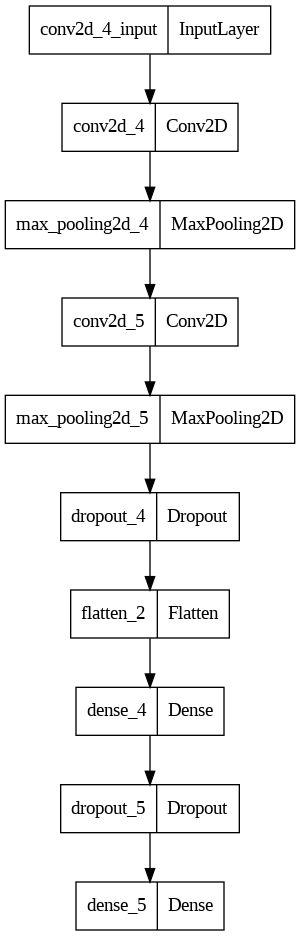

In [68]:
plot_model(model)

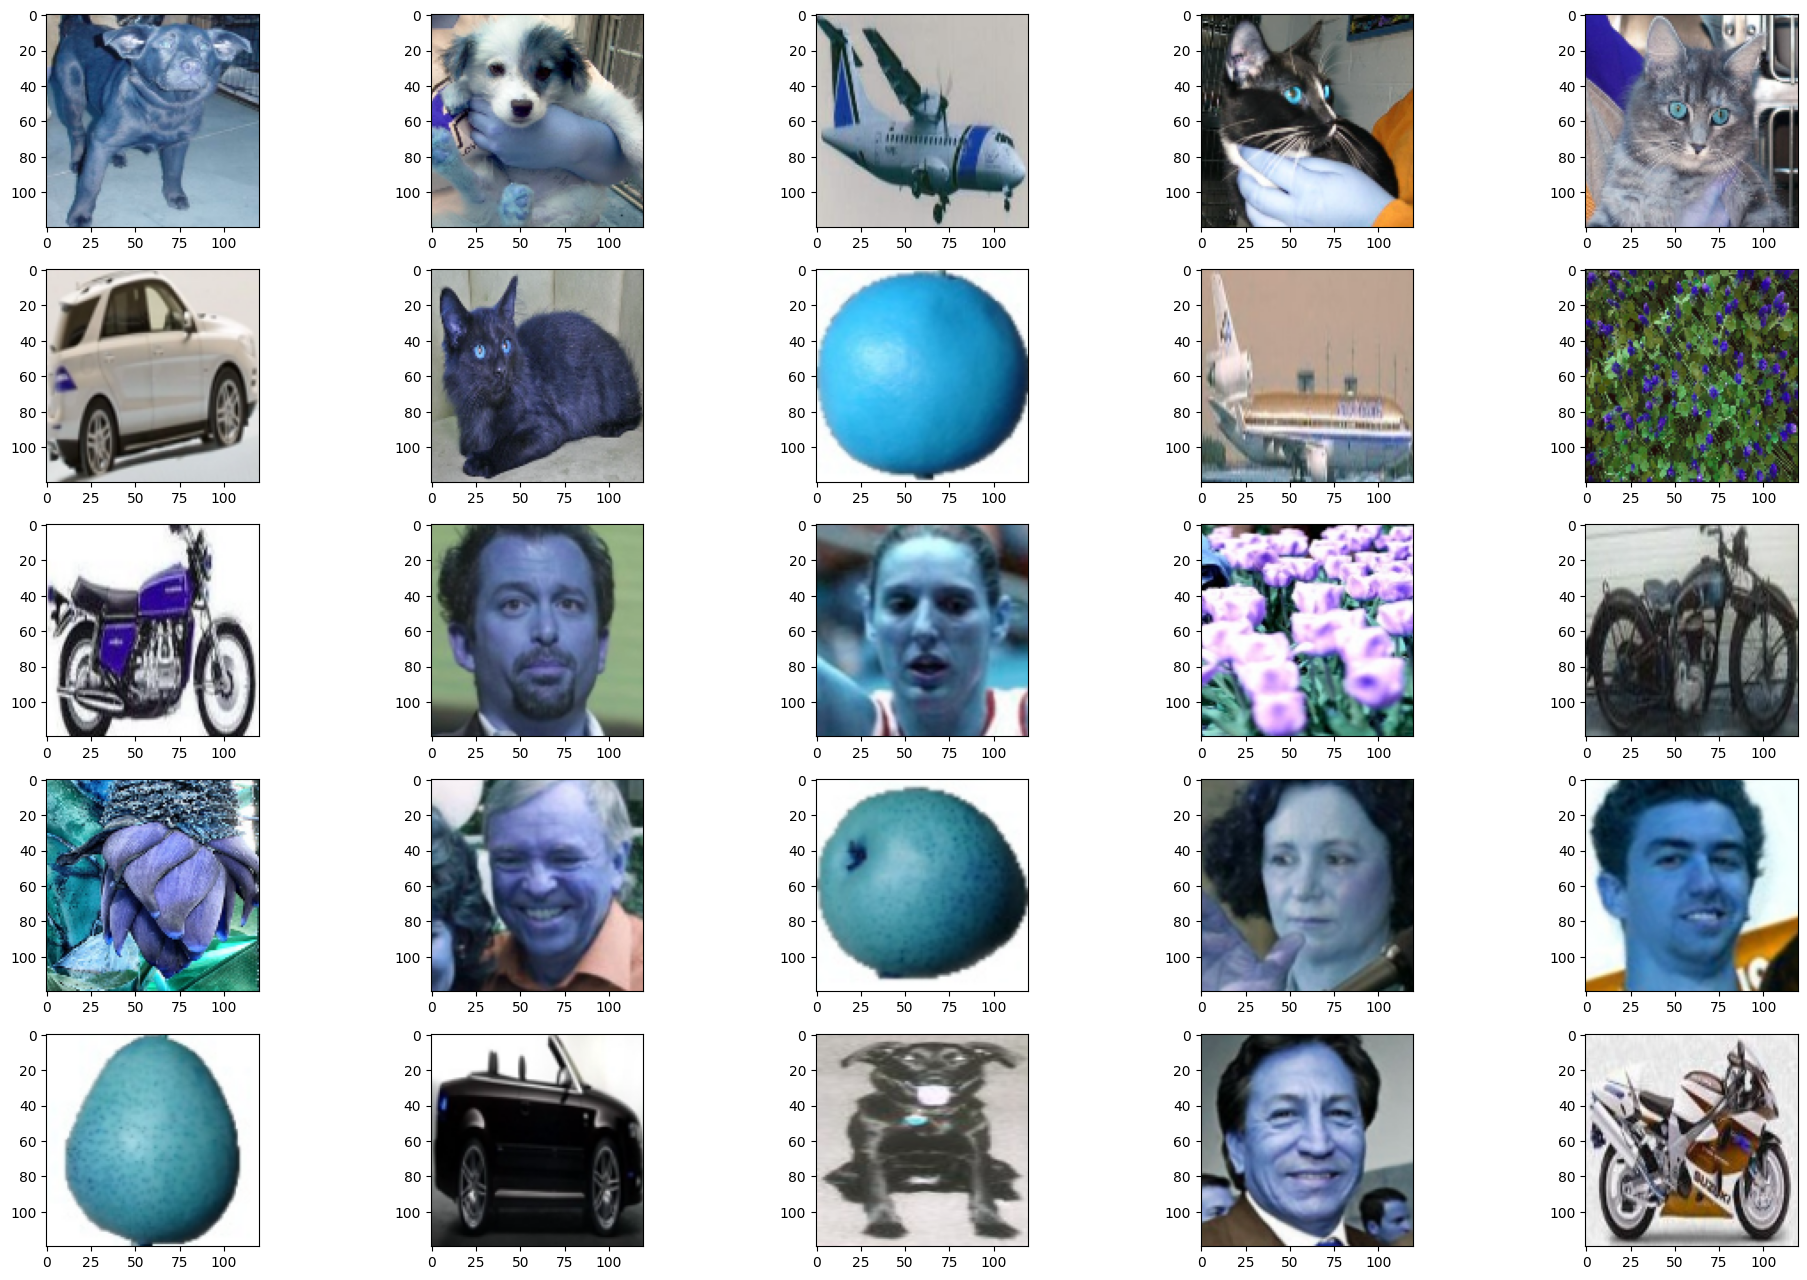

In [69]:
fig = plt.figure(figsize=(24, 16))

for s in range(len(X_test[:25])):
    numberplt = s+1
    fig.add_subplot(5, 5, numberplt)
    plt.imshow(X_test[s])
    pass

# Accuracy Score

In [70]:
Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_test = np.argmax(Y_test, axis = 1)
print(Y_pred,'\n',Y_test)
accuracy_score(Y_pred,Y_test)

72/72 [==============================] - 0s 6ms/step
[3 3 0 ... 2 3 3] 
 [3 3 0 ... 2 3 0]


0.9104084321475626

In [71]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       214
           1       0.93      0.95      0.94       326
           2       0.76      0.81      0.78       287
           3       0.78      0.62      0.69       235
           4       0.95      0.91      0.93       291
           5       0.94      1.00      0.97       325
           6       1.00      0.98      0.99       250
           7       0.96      0.99      0.97       349

    accuracy                           0.91      2277
   macro avg       0.91      0.90      0.90      2277
weighted avg       0.91      0.91      0.91      2277



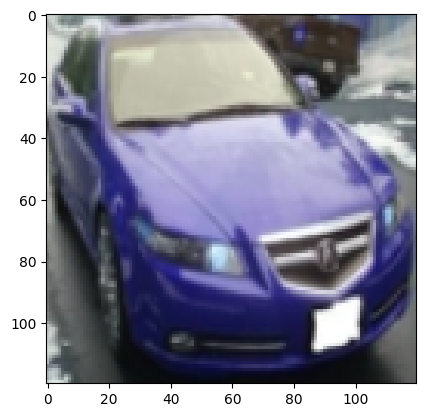

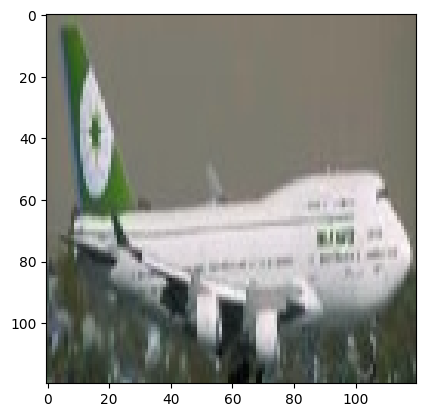

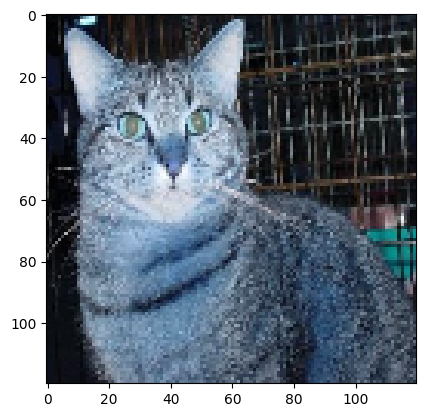

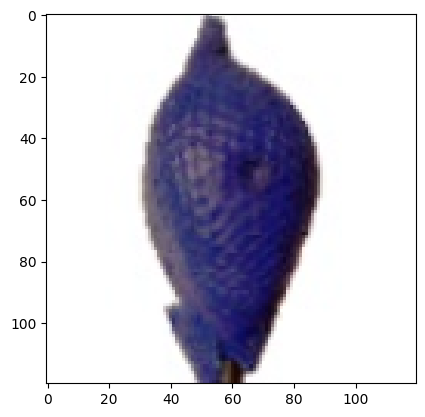

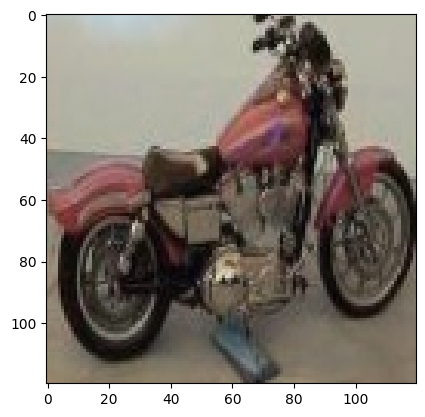

In [72]:
z = X_test[116:121]
for i in z:
    plt.imshow(i)
    plt.show()

1/1 [==============================] - 0s 19ms/step


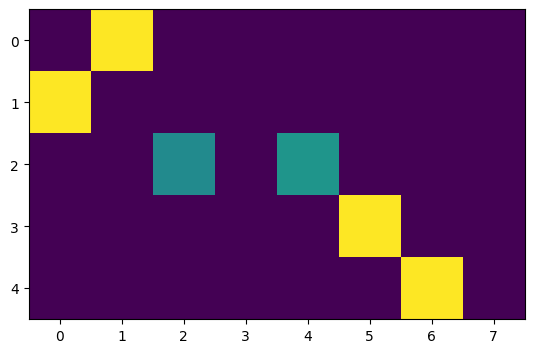

In [74]:
x = model.predict(X_test[116:121])
plt.imshow(x)
plt.show()

In [75]:
Y_pred[:20]

array([3, 3, 0, 2, 2, 1, 5, 5, 0, 4, 6, 7, 7, 4, 6, 4, 7, 5, 7, 7])

In [76]:
Y_test[:20]

array([3, 3, 0, 2, 2, 1, 2, 5, 0, 4, 6, 7, 7, 4, 6, 4, 7, 5, 7, 7])

# Notes
- Thank for reading my classification.

- If you any questions or advice me please write in the comment.

- If anyone has a model with a higher percentage, please tell me, its will support me .

# Vote
-  If you liked my work upvote me

# The End...